In [1]:
from lib.video_dataset import VideoFrameDataset
from config.torch_config import get_transform, device, unnormalize
from config.dataset import get_dataset_path


## HYPERPARAMETERS

In [2]:
from config.const import *


In [3]:
data_path, model_path = get_dataset_path(dataset="WLASL/videos", model_name="WLASL_5")
multiple_transform = get_transform(IMAGE_SIZE)


In [4]:
dataset = VideoFrameDataset(
    root_path=data_path,
    transform=multiple_transform,
    image_size=IMAGE_SIZE,
    num_segments=NUM_SEGMENTS,
    frames_per_segment=FRAMES_PER_SEGMENT,
)

classes = dataset.classes
print(classes)


['before', 'book', 'chair', 'computer', 'drink']


In [5]:
from utils.loader import split_dataset


In [6]:
train_loader, test_loader, validation_loader = split_dataset(
    dataset, train_split=0.70, validation_split=0.1, batch_size=BATCH_SIZE
)


In [7]:
print(len(train_loader), len(validation_loader), len(test_loader))


14 2 4


### Example of input of net

> Initial input = [BATCH_SIZE, NUMBER_OF_FRAMES, CHANNELS, HEIGHT, WIDTH]

This example shows first example (first video) in first batch

In [8]:
from utils.output import plot_tensor
from torchvision.utils import make_grid
from torch import nn


In [9]:
def plot_grid(
    tensor, dims=(1, 2, 0), nrow=FRAMES_PER_SEGMENT*NUM_SEGMENTS, unnorm=True, start_dim=0, end_dim=1
):
    flat = nn.Flatten(start_dim=start_dim, end_dim=end_dim) # Flatten batch to plot.

    flatted_tensor = flat(tensor)
    grid = make_grid(flatted_tensor.cpu(), nrow=nrow)

    if unnorm:
        grid = unnormalize(grid)

    plot_tensor(grid, dims)


### Show input of the net (entire batch)

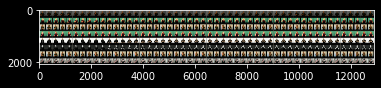

torch.Size([8, 50, 3, 256, 256])
torch.Size([8])
torch.Size([8, 4200])


In [10]:
first_batch, (ground_classes, ground_poses) = next(iter(train_loader))
plot_grid(first_batch)

print(first_batch.shape)
print(ground_classes.shape)
print(ground_poses.shape)

In [11]:
n_video = 1
frame_of_video = 5


### Show pose for gesture

In [12]:
import matplotlib.pyplot as plt

In [13]:
video_poses = ground_poses[n_video]
img_pose = video_poses[frame_of_video]

# POSE_POINTS = img_pose.shape[0]
# print(f"Pose points: {POSE_POINTS}")

# TODO: Delete this
POSE_POINTS = video_poses.shape[0]

# x, y = img_pose[:, 0], img_pose[:, 1]
# plt.scatter(x, y)
# plt.gca().invert_yaxis()


### Show one video alone

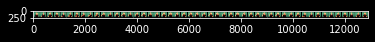

In [14]:
video = first_batch[n_video]
plot_grid(video, nrow=len(video), end_dim=0)

### Show one image

drink


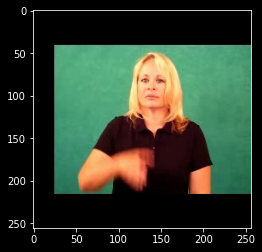

In [15]:
img = video[frame_of_video]
target = ground_classes[n_video]

print(classes[target])
plot_grid(img, end_dim=0)

### Show pose and image one on top of the other

In [16]:
unorm_img = unnormalize(img)

# plt.scatter(x, y)
# plt.imshow(unorm_img.permute(1, 2, 0))
# plt.show()


### The net will then make first and second convolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 16, 2, 128, 128])
torch.Size([8, 32, 1, 64, 64])


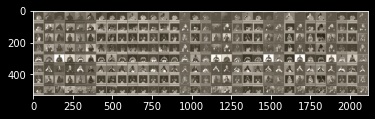

In [17]:
hidden_1, hidden_2 = 16, 32

conv1 = nn.Conv3d(FRAMES_PER_SEGMENT*NUM_SEGMENTS, hidden_1, kernel_size=(2, 3, 3), stride=2, padding=1)
conv2 = nn.Conv3d(hidden_1, hidden_2, kernel_size=3, stride=2, padding=1)
relu = nn.LeakyReLU()
batch_1 = nn.BatchNorm3d(hidden_1)
batch_2 = nn.BatchNorm3d(hidden_2)

x = first_batch

x = conv1(x)
x = relu(x)
x = batch_1(x)

print(x.shape)

x = conv2(x)
x = relu(x)
x = batch_2(x)

print(x.shape)


plot_grid(x, nrow=hidden_2)

## Check balance status of the loaders

In [18]:
# from nets.common.utils.balance import check_balance_status

# print(check_balance_status(test_loader, classes))
# print(check_balance_status(validation_loader, classes))
# print(check_balance_status(train_loader, classes))


In [19]:
from lib.model import CNN

model = CNN(
    num_classes=len(classes),
    num_frames=FRAMES_PER_SEGMENT * NUM_SEGMENTS,
    image_size=IMAGE_SIZE,
    num_pose_points=POSE_POINTS,
)

# print(model)


In [20]:
from torchinfo import summary

summary(model)


Layer (type:depth-idx)                   Param #
CNN                                      --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv3d: 3-1                  14,416
│    │    └─MaxPool3d: 3-2               --
│    │    └─BatchNorm3d: 3-3             32
│    └─Sequential: 2-2                   --
│    │    └─Conv3d: 3-4                  13,856
│    │    └─MaxPool3d: 3-5               --
│    │    └─BatchNorm3d: 3-6             64
├─Sequential: 1-2                        --
│    └─Sequential: 2-3                   --
│    │    └─Linear: 3-7                  16,779,264
│    │    └─LeakyReLU: 3-8               --
│    └─Dropout: 2-4                      --
├─Sequential: 1-3                        --
│    └─Sequential: 2-5                   --
│    │    └─Linear: 3-9                  10,245
│    │    └─LeakyReLU: 3-10              --
│    └─Softmax: 2-6                      --
├─Sequential: 1-4                        --
│    └─

In [21]:
from lib.train import train_model


In [22]:
train_costs, val_costs, train_accs, val_accs = train_model(
    model,
    train_loader,
    validation_loader,
    device,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
)


Training on device: cuda
Epoch: 1/100 | Train Loss: 3977899.8036 | Val Loss: 4562573.7500 | Train Acc: 15.5963% | Val Acc: 37.5000% |  LR: 0.001
Epoch: 2/100 | Train Loss: 3967723.7679 | Val Loss: 4556670.2500 | Train Acc: 23.8532% | Val Acc: 56.2500% |  LR: 0.001
Epoch: 3/100 | Train Loss: 3944689.9821 | Val Loss: 4555361.2500 | Train Acc: 37.6147% | Val Acc: 43.7500% |  LR: 0.001
Epoch: 4/100 | Train Loss: 3922738.8036 | Val Loss: 4554080.0000 | Train Acc: 33.9450% | Val Acc: 62.5000% |  LR: 0.001
Epoch: 5/100 | Train Loss: 3898295.2679 | Val Loss: 4552450.0000 | Train Acc: 35.7798% | Val Acc: 56.2500% |  LR: 0.001
Epoch: 6/100 | Train Loss: 3935944.6607 | Val Loss: 4551550.5000 | Train Acc: 35.7798% | Val Acc: 56.2500% |  LR: 0.001
Epoch: 7/100 | Train Loss: 3969028.9286 | Val Loss: 4552663.5000 | Train Acc: 39.4495% | Val Acc: 62.5000% |  LR: 0.001
Epoch: 8/100 | Train Loss: 3951359.3929 | Val Loss: 4550543.7500 | Train Acc: 32.1101% | Val Acc: 56.2500% |  LR: 0.001
Epoch: 9/100 | 

In [23]:
from utils.output import plot_train_val_data

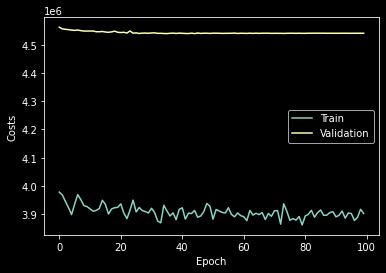

<Figure size 72x72 with 0 Axes>

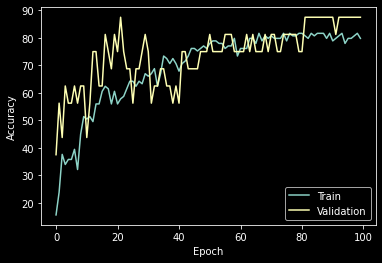

<Figure size 72x72 with 0 Axes>

In [24]:
plot_train_val_data(train_costs, val_costs, ylabel="Costs")
plot_train_val_data(train_accs, val_accs, ylabel="Accuracy")


In [25]:
import sys

sys.path.append("../")

from common.utils.check_accuracy import check_accuracy


## Probamos el acc con el dataset de prueba reservado

In [26]:
check_accuracy(train_loader, model, classes, device, n_batchs=10)


Predictions for batch 1 
['drink', 'drink', 'before', 'book', 'drink', 'book', 'computer', 'computer']
Ground truth for batch 1
['drink', 'drink', 'before', 'book', 'before', 'book', 'computer', 'computer']
---------------------------------


Predictions for batch 2 
['drink', 'book', 'drink', 'computer', 'before', 'drink', 'book', 'book']
Ground truth for batch 2
['drink', 'chair', 'before', 'computer', 'before', 'drink', 'book', 'book']
---------------------------------


Predictions for batch 3 
['computer', 'chair', 'drink', 'book', 'book', 'book', 'chair', 'drink']
Ground truth for batch 3
['computer', 'chair', 'before', 'book', 'book', 'before', 'chair', 'drink']
---------------------------------


Predictions for batch 4 
['chair', 'book', 'book', 'drink', 'drink', 'drink', 'drink', 'book']
Ground truth for batch 4
['chair', 'book', 'chair', 'before', 'drink', 'drink', 'drink', 'book']
---------------------------------


Predictions for batch 5 
['book', 'book', 'book', 'drink',

In [27]:
check_accuracy(validation_loader, model, classes, device)

Predictions for batch 1 
['book', 'book', 'drink', 'computer', 'chair', 'drink', 'book', 'book']
Ground truth for batch 1
['book', 'book', 'drink', 'computer', 'chair', 'drink', 'before', 'book']
---------------------------------


Predictions for batch 2 
['computer', 'drink', 'before', 'computer', 'drink', 'book', 'computer', 'book']
Ground truth for batch 2
['computer', 'drink', 'book', 'computer', 'drink', 'book', 'computer', 'book']
---------------------------------


Got 14 / 16 with accuracy 87.50


In [28]:
check_accuracy(test_loader, model, classes, device)

Predictions for batch 1 
['book', 'before', 'book', 'drink', 'computer', 'book', 'computer', 'before']
Ground truth for batch 1
['book', 'computer', 'book', 'before', 'computer', 'book', 'before', 'book']
---------------------------------


Predictions for batch 2 
['computer', 'chair', 'book', 'book', 'drink', 'drink', 'computer', 'book']
Ground truth for batch 2
['before', 'before', 'book', 'chair', 'computer', 'drink', 'chair', 'chair']
---------------------------------


Predictions for batch 3 
['computer', 'drink', 'drink', 'computer', 'drink', 'drink', 'book', 'before']
Ground truth for batch 3
['computer', 'before', 'computer', 'before', 'drink', 'drink', 'computer', 'chair']
---------------------------------


Predictions for batch 4 
['book', 'drink', 'book', 'chair', 'book', 'chair', 'drink', 'drink']
Ground truth for batch 4
['computer', 'drink', 'chair', 'chair', 'book', 'book', 'before', 'drink']
---------------------------------


Got 13 / 32 with accuracy 40.62


## Exportamos modelo

In [29]:
from torch import save

In [30]:
save(model, model_path)
print(f"Model exported to {model_path}")


Model exported to d:\Proyectos\TFG\Sign2Text\Project\models\WLASL_5.pth


TODO: Add export to onxx para visualizar en la página esa chula o usar tensorboard